<a href="https://colab.research.google.com/github/sungjindo/black_coal_price/blob/main/Prophet_Coal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1.모듈 불러오기**








In [ ]:
# 기본 라이브러리
import pandas as pd
import numpy as np
import os

# 시각화 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
from plotly.offline import init_notebook_mode, iplot #plotly offline mode 
init_notebook_mode(connected = True)
import plotly.graph_objs as go #plotly graphical object
%matplotlib notebook
%matplotlib inline

# 통계 및 기계학습 관련 라이브러리
from scipy import stats    # 통계 관련 라이브러리
from sklearn.model_selection import train_test_split, RandomizedSearchCV    # 데이터 셋 분류 라이브러리
from sklearn.utils import resample    # 데이터 업샘플링&다운샘플링 라이브러리
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTEENN    # 복합샘플링 라이브러리
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler    # 데이터 스케일링 라이브러리
from statsmodels.stats.outliers_influence import variance_inflation_factor    # 변수 간 다중공선성 확인(VIF) 라이브러리
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, plot_confusion_matrix, plot_roc_curve)    # 모델 정확도 검증 라이브러리
from sklearn.model_selection import cross_val_score, train_test_split   # validation  검증 라이브러리

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')
import statsmodels.api as sm    # 통계분석 관련 라이브러리
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error


import warnings    # 경고문구 지우기
warnings.filterwarnings("ignore")

from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.plot import plot_plotly, plot_components_plotly


from google.colab import drive
drive.mount('/content/gdrive')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



Mounted at /content/gdrive


# **2.data**


In [ ]:
df = pd.read_csv("/content/gdrive/My Drive/Black_coal/data/usethis.csv", encoding = 'utf-8-sig')
df = df.sort_values('ds')
df['ds']= pd.to_datetime(df['ds'])

df = df.set_index('ds')
df = df[df.index < '2019-04-01']
df = df.reset_index()
df

,ds,Coal,iron,Brent_fut,copper_fut,WTI_fut,WTI,LNG_fut,BDI,AUD_dollar,...,FTSE,DAX,S&P500,HSI,IXIC,KOSPI,Nikkei225,SX5E,ASX,TSX
0,2011-01-01,122.65,168.30,94.75,9644.00,91.38,91.40,61.07,1773.0,0.98447,...,5899.899902,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195
1,2011-01-02,122.65,168.30,94.75,9644.00,91.38,91.40,61.07,1773.0,0.98447,...,5899.899902,6914.189941,1257.640015,23035.449219,2652.870117,2051.000000,10228.919922,2807.040039,4745.200195,13443.200195
2,2011-01-03,136.50,170.00,94.84,9644.00,91.55,91.56,61.07,1773.0,0.97901,...,5899.899902,6989.740234,1271.869995,23436.050781,2691.520020,2070.080078,10228.919922,2839.429932,4745.200195,13443.200195
3,2011-01-04,137.30,172.10,93.53,9619.25,89.38,89.23,58.32,1693.0,0.98337,...,6013.899902,6975.350098,1270.199951,23668.480469,2681.250000,2085.139893,10398.099609,2844.169922,4742.500000,13402.299805
4,2011-01-05,130.65,174.50,95.50,9586.00,90.30,90.38,56.40,1621.0,0.99285,...,6043.899902,6939.819824,1276.560059,23757.820312,2702.199951,2082.550049,10380.769531,2833.739990,4714.899902,13396.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3007,2019-03-27,93.50,85.72,67.83,6336.00,59.41,59.12,37.47,690.0,1.40115,...,7194.200195,11419.040039,2805.370117,28728.250000,7643.379883,2145.620117,21378.730469,3322.040039,6136.000000,16132.500000
3008,2019-03-28,92.95,85.64,67.82,6368.75,59.30,59.30,36.05,692.0,1.41153,...,7234.299805,11428.160156,2815.439941,28775.210938,7669.169922,2128.100098,21033.759766,3320.290039,6176.100098,16155.500000
3009,2019-03-29,92.75,85.70,68.39,6475.75,60.14,59.98,34.61,689.0,1.41180,...,7279.200195,11526.040039,2834.399902,29051.359375,7729.319824,2140.669922,21205.810547,3351.709961,6180.700195,16102.099609
3010,2019-03-30,92.75,85.70,68.39,6475.75,60.14,59.98,34.61,689.0,1.41180,...,7279.200195,11526.040039,2834.399902,29051.359375,7729.319824,2140.669922,21205.810547,3351.709961,6180.700195,16102.099609


# **3.Prophet model**
  -Basic

##3.1 2019년 1분기

In [ ]:
def prophetm(df, z, x, y , d_start) :
  
        #a = prophetm(z, x, y) 
        df1 = df[['ds', z]]
      
    
        df1.columns = ['ds', 'y']
        df1['ds']= pd.to_datetime(df1['ds'])
        
      
        train = df1.drop(df.index[x:])
        y_true = df1['y'][y:].values 
        
      
        last_1year = pd.date_range(d_start, periods=90)
        last_1year = list(last_1year)
        last_1year = pd.DataFrame(last_1year, columns = ['ds'])
        last_1year['ds']= pd.to_datetime(last_1year['ds'])
        m = Prophet(
        # trend
                changepoint_prior_scale=0.05,
        # seasonality
                weekly_seasonality=10,
                yearly_seasonality=20,
              daily_seasonality=False,)
        m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
        forecast = m.fit(train).predict(last_1year)
        # fig = m.plot_components(forecast)
        # a = add_changepoints_to_plot(fig.gca(), m, forecast)
        y_pred = forecast['yhat'].values
       
        return y_pred, last_1year['ds'], y_true
      
# z = str(input('컬럼명 입력(''제외 입력): '))
# x = int(input('삭제할 주 단위를 입력해주세요(-붙여서): '))
# y = int(input('필요한 y값의 월 단위를 입력해주세요(-붙여서): '))




# print('-------------done------------')
# print('y_pred result: {} '  .format(y_pred))


MAE: 22.975
MAPE: 0.238


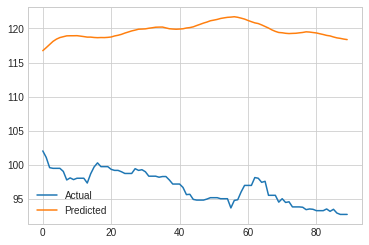

In [ ]:

y_tt = prophetm(df, 'Coal', -90, -90,'2019-01-01')
y_tt = pd.DataFrame(y_tt)
y_tt = y_tt.T
y_tr = y_tt[[1,2]]
y_tr = y_tr.rename(columns ={2:'y_true',1:'ds'})
y_tt = y_tt[[1,0]]
y_tt = y_tt.rename(columns ={0:'y_pred',1:'ds'})
# print(y_tt)
# print(y_true)

# 예측하고 비교하기
# 여기에서는 MAE를 살펴본다.

y_pred = y_tt['y_pred'].values
y_true = y_tr['y_true'].values
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)

print('MAE: %.3f' % mae)
print('MAPE: %.3f' % mape)
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

##3.2 2019년 2분기

MAE: 31.012
MAPE: 0.395


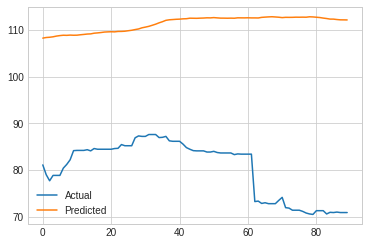

In [ ]:
df = pd.read_csv("/content/gdrive/My Drive/Black_coal/data/usethis.csv", encoding = 'utf-8-sig')
df = df.sort_values('ds')
df['ds']= pd.to_datetime(df['ds'])

df = df.set_index('ds')
df = df[df.index < '2019-07-01']
df = df.reset_index()


y_tt = prophetm(df, 'Coal', -90, -90,'2019-07-01')
y_tt = pd.DataFrame(y_tt)
y_tt = y_tt.T
y_tr = y_tt[[1,2]]
y_tr = y_tr.rename(columns ={2:'y_true',1:'ds'})
y_tt = y_tt[[1,0]]
y_tt = y_tt.rename(columns ={0:'y_pred',1:'ds'})

y_pred = y_tt['y_pred'].values
y_true = y_tr['y_true'].values
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)

print('MAE: %.3f' % mae)
print('MAPE: %.3f' % mape)
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

##3.3 2019년 3분기

MAE: 26.112
MAPE: 0.383


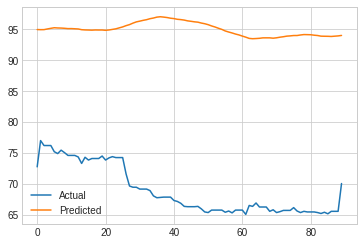

In [ ]:
df = pd.read_csv("/content/gdrive/My Drive/Black_coal/data/usethis.csv", encoding = 'utf-8-sig')
df = df.sort_values('ds')
df['ds']= pd.to_datetime(df['ds'])

df = df.set_index('ds')
df = df[df.index < '2019-10-01']
df = df.reset_index()


y_tt = prophetm(df, 'Coal', -90, -90,'2019-10-01')
y_tt = pd.DataFrame(y_tt)
y_tt = y_tt.T
y_tr = y_tt[[1,2]]
y_tr = y_tr.rename(columns ={2:'y_true',1:'ds'})
y_tt = y_tt[[1,0]]
y_tt = y_tt.rename(columns ={0:'y_pred',1:'ds'})

y_pred = y_tt['y_pred'].values
y_true = y_tr['y_true'].values
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)

print('MAE: %.3f' % mae)
print('MAPE: %.3f' % mape)
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

##3.4 2019년 4분기

MAE: 5.714
MAPE: 0.085


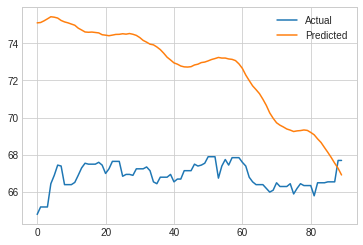

In [ ]:
df = pd.read_csv("/content/gdrive/My Drive/Black_coal/data/usethis.csv", encoding = 'utf-8-sig')
df = df.sort_values('ds')
df['ds']= pd.to_datetime(df['ds'])

df = df.set_index('ds')
df = df[df.index < '2020-01-01']
df = df.reset_index()


y_tt = prophetm(df, 'Coal', -90, -90,'2020-01-01')
y_tt = pd.DataFrame(y_tt)
y_tt = y_tt.T
y_tr = y_tt[[1,2]]
y_tr = y_tr.rename(columns ={2:'y_true',1:'ds'})
y_tt = y_tt[[1,0]]
y_tt = y_tt.rename(columns ={0:'y_pred',1:'ds'})

y_pred = y_tt['y_pred'].values
y_true = y_tr['y_true'].values
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)

print('MAE: %.3f' % mae)
print('MAPE: %.3f' % mape)
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()